# Predicting Heart Disease using Logistic Regression

### Introduction

World Health Organization has  estimated 12 million deaths occur worldwide, every year due to Heart diseases. Half the deaths in the United States and other developed countries are due to cardio vascular diseases. The early prognosis of cardiovascular diseases can aid in making decisions on lifestyle changes in high risk patients and in turn reduce the complications. This research intends to pinpoint the most relevant/risk factors of heart disease as well as predict the overall risk using logistic regression.


In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.mlab as mlab
%matplotlib inline

## Data Preparation

### Source:

The dataset is publically available on the Kaggle website, and it is from an ongoing ongoing cardiovascular study on residents of the town of Framingham, Massachusetts.  The classification goal is to predict whether the patient has 10-year risk of future coronary heart disease (CHD).The dataset provides the patients’ information. It includes over 4,000 records and 15 attributes.

In [3]:
url = 'https://raw.githubusercontent.com/ayonroy2000/Talks/master/framingham.csv?token=AKG32T2IBXSNHIDY56KUWFK65ZEWY'
heart_df= pd.read_csv(url)
heart_df.drop(['education'],axis=1,inplace=True)
heart_df.head()

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


### Variables :

Each attribute is a potential risk factor. There are both demographic, behavioural and medical risk factors.

 - Demographic:
sex: male or female;(Nominal)

    -  age: age of the patient;(Continuous - Although the recorded ages have been truncated to whole numbers, the concept of age is continuous)


 - Behavioural:

    -  currentSmoker: whether or not the patient is a current smoker (Nominal)

    -  cigsPerDay: the number of cigarettes that the person smoked on average in one day.(can be considered continuous as one can have any number of cigarretts, even half a cigarette.)

 - Medical( history):

    -  BPMeds: whether or not the patient was on blood pressure medication (Nominal)

    -  prevalentStroke: whether or not the patient had previously had a stroke (Nominal)

    -  prevalentHyp: whether or not the patient was hypertensive (Nominal)

    -  diabetes: whether or not the patient had diabetes (Nominal)

 - Medical(current):

    -  totChol: total cholesterol level (Continuous)

    -  sysBP: systolic blood pressure (Continuous)

    -  diaBP: diastolic blood pressure (Continuous)

    -  BMI: Body Mass Index (Continuous)

    -  heartRate: heart rate (Continuous - In medical research, variables such as heart rate though in fact discrete, yet are considered continuous because of large number of possible values.)

    -  glucose: glucose level (Continuous)


 - Predict variable (desired target):

    -  10 year risk of coronary heart disease CHD (binary: “1”, means “Yes”, “0” means “No”)


In [4]:
heart_df.rename(columns={'male':'Gender_male'},inplace=True)

### Missing values

In [5]:
heart_df.isnull().sum()

Gender_male          0
age                  0
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

In [6]:
count=0
for i in heart_df.isnull().sum(axis=1):
    if i>0:
        count=count+1
print('Total number of rows with missing values is ', count)
print('since it is only',round((count/len(heart_df.index))*100), 'percent of the entire dataset the rows with missing values are excluded.')

Total number of rows with missing values is  489
since it is only 12 percent of the entire dataset the rows with missing values are excluded.


In [7]:
heart_df.dropna(axis=0,inplace=True)

## Exploratory Analysis

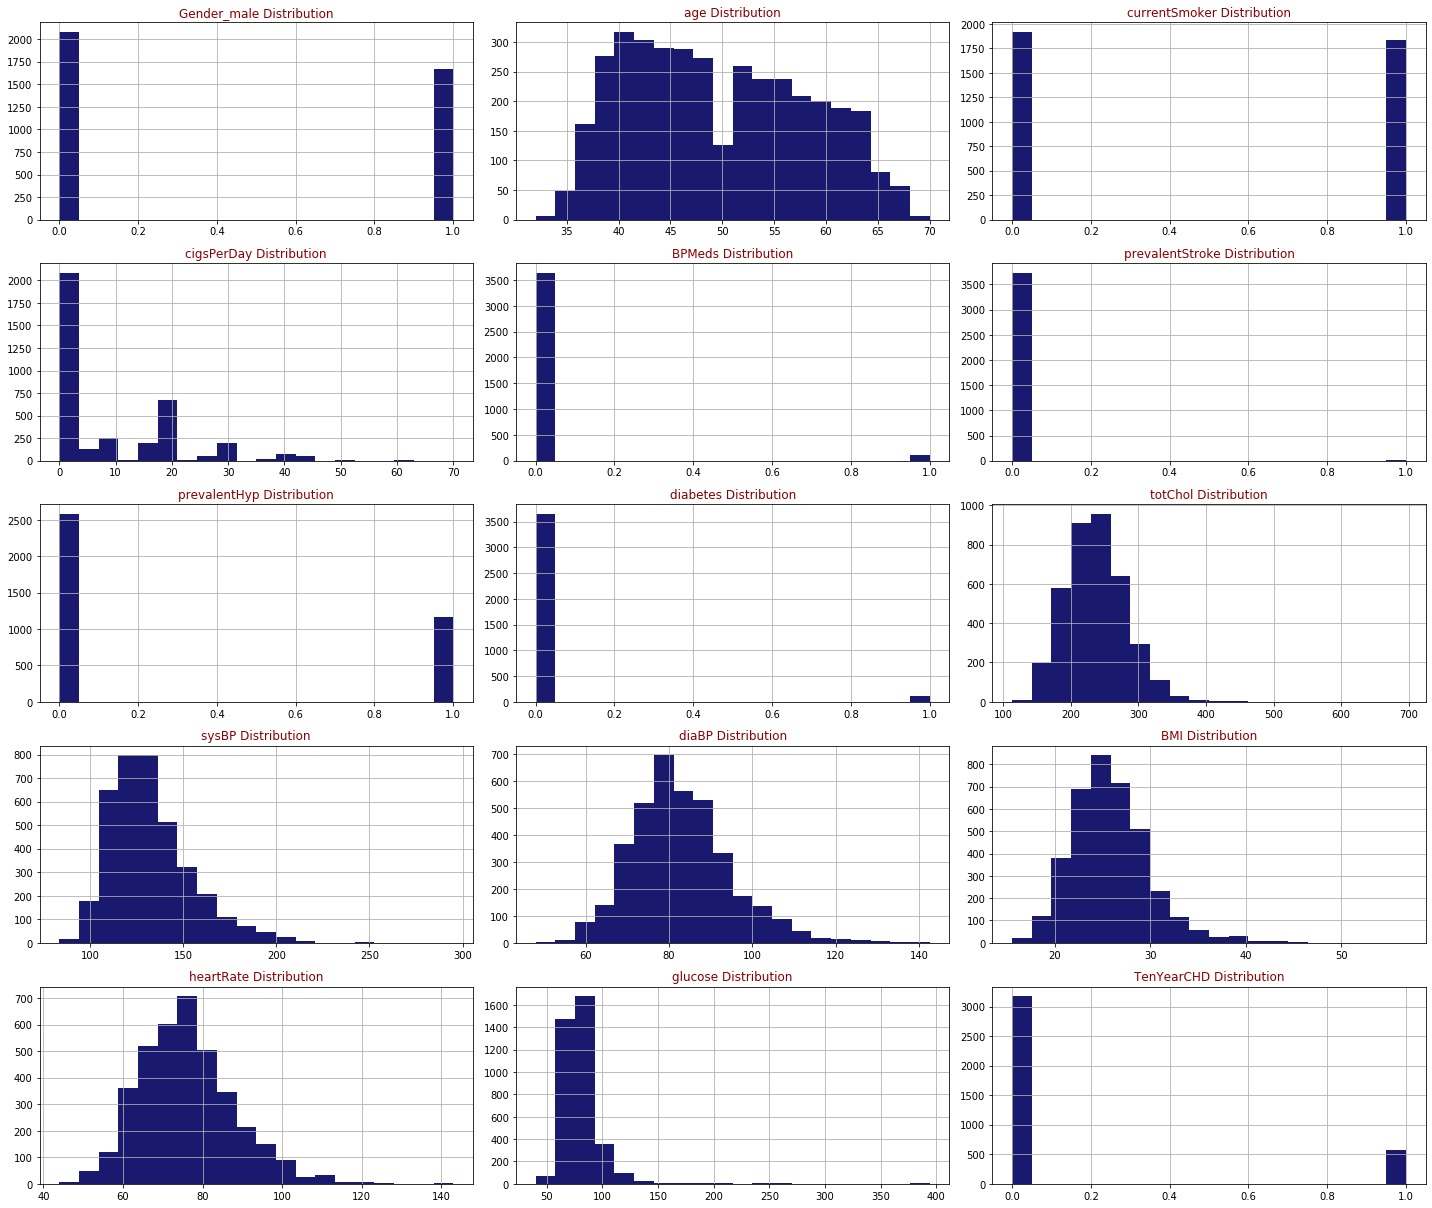

In [8]:
def draw_histograms(dataframe, features, rows, cols):
    fig=plt.figure(figsize=(20,20))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe[feature].hist(bins=20,ax=ax,facecolor='midnightblue')
        ax.set_title(feature+" Distribution",color='DarkRed')
        
    fig.tight_layout()  
    plt.show()
draw_histograms(heart_df,heart_df.columns,6,3)

In [9]:
heart_df.TenYearCHD.value_counts()

0    3179
1     572
Name: TenYearCHD, dtype: int64

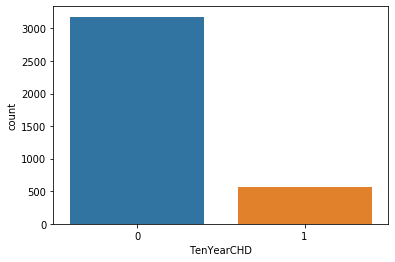

In [10]:
sn.countplot(x='TenYearCHD',data=heart_df)

There are 3179 patents with no heart disease and 572 patients with risk of heart disease.

In [11]:
heart_df.describe()

,Gender_male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000
mean,0.445215,49.573447,0.488403,9.008531,0.030392,0.005599,0.311917,0.027193,236.928019,132.368435,82.938550,25.808288,75.704079,81.880032,0.152493
std,0.497056,8.570204,0.499932,11.925097,0.171686,0.074623,0.463338,0.162666,44.611594,22.046522,11.932779,4.065599,11.956382,23.882233,0.359546
min,0.000000,32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,113.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.085000,68.000000,71.000000,0.000000
50%,0.000000,49.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.410000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,264.000000,144.000000,90.000000,28.060000,82.000000,87.000000,0.000000
max,1.000000,70.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000


## Logistic Regression

Logistic regression is a type of regression analysis in statistics used for prediction of outcome of a categorical dependent variable from a set of predictor or independent variables. In logistic regression the dependent variable is always binary. Logistic regression is mainly used to for prediction and also calculating the probability of success. 

## Logistic Regression is one of the basic and popular algorithms to solve a binary classification problems

For each input, logistic regression outputs a probability that this input belongs to the 2 classes

Set a probability threshold boundary and that determines which class the input belongs to

Binary classification problems (2 classes)

Emails (Spam / Not Spam)

Transactions (Fraudulent / Not Fraudulent)

Loan Default (Yes / No)

# Why Not Use Linear Regression for Classification?

Linear regression is used to solve regression problems with continuous values

Logistic regression is used to solve classification problems with discrete categories

Binary classification (Classes 0 and 1)

 The difference between Linear Regression and Logistic Regression can be represented diagrammatically as follows-
   
   
   ![Linear Regression Vs Logistic Regression](https://external-content.duckduckgo.com/iu/?u=http%3A%2F%2Fres.cloudinary.com%2Fdyd911kmh%2Fimage%2Fupload%2Ff_auto%2Cq_auto%3Abest%2Fv1534281070%2Flinear_vs_logistic_regression_edxw03.png&f=1&nofb=1)
   

## Implement linear equation


Logistic Regression algorithm works by implementing a linear equation with independent or explanatory variables to predict a response value. For example, we consider the example of number of hours studied and probability of passing the exam. Here, number of hours studied is the explanatory variable and it is denoted by x1. Probability of passing the exam is the response or target variable and it is denoted by z. 


If we have one explanatory variable (x1) and one response variable (z), then the linear equation would be given mathematically with the following equation- 


 	z = β0 + β1x1


Here, the coefficients β0 and β1 are the parameters of the model.


If there are multiple explanatory variables, then the above equation can be extended to 


	z = β0 + β1x1+ β2x2+……..+ βnxn


Here, the coefficients β0, β1, β2 and βn are the parameters of the model.


So, the predicted response value is given by the above equations and is denoted by z.

 
# Sigmoid Function


This predicted response value, denoted by z is then converted into a probability value that lie between 0 and 1. We use the **sigmoid function** in order to map predicted values to probability values. This sigmoid function then maps any real value into a probability value between 0 and 1. 


In machine learning, sigmoid function is used to map predictions to probabilities. The sigmoid function has an `S` shaped curve. It is also called **sigmoid curve**.  


A `Sigmoid function` is a special case of the `Logistic function`. It is given by the following mathematical formula. 

The logisitc also called as logit is denoted by σ is a sigmoid function and it outputs a number between 0 and 1.

![](https://imgur.com/DNpFtRM.png)

*source* : https://www.oreilly.com/library/view/hands-on-machine-learning/9781491962282/


* Positive values are predictive of class 1
* Negative values are predictive of class 0

# Types of Logistic Regression


Logistic Regression model can be classified into three groups based on the target variable categories. These three groups are described below:-


1.	**Binary Logistic Regression**


In **Binary Logistic Regression**, the target variable has two possible categories. The common examples of categories are `yes or no`, `good or bad`, `true or false`, `spam or no spam` and `pass or fail`.


2.	**Multinomial Logistic Regression**


In **Multinomial Logistic Regression**, the target variable has three or more categories which are not in any particular order. So, there are three or more nominal categories. The examples include the type of categories of fruits - `apple`, `mango`, `orange` and `banana`.


3.	**Ordinal Logistic Regression**


In **Ordinal Logistic Regression**, the target variable has three or more ordinal categories. So, there is intrinsic order involved with the categories. For example, the student performance can be categorized as `poor`, `average`, `good` and `excellent`.


# Decision boundary


The sigmoid function returns a probability value between 0 and 1. This probability value is then mapped to a discrete class which is either “0” or “1”. In order to map this probability value to a discrete class (pass/fail, yes/no, true/false), we select a threshold value. This threshold value is called **Decision boundary**. Above this threshold value, we will map the probability values into class 1 and below which we will map values into class 0.


Mathematically, it can be expressed as follows:-


	p ≥ 0.5 => class = 1
	
	
	p < 0.5 => class = 0 
	

Generally, the decision boundary is set to 0.5. So, if the probability value is 0.8 (> 0.5), we will map this observation to class 1.  Similarly, if the probability value is 0.2 (< 0.5), we will map this observation to class 0.


![Decision boundary](https://external-content.duckduckgo.com/iu/?u=http%3A%2F%2Fwww.holehouse.org%2Fmlclass%2F06_Logistic_Regression_files%2FImage%2520%5B5%5D.png&f=1&nofb=1)


# Making predictions


Now, we know about `sigmoid function` and `decision boundary` in logistic regression. We can use our knowledge of `sigmoid function` 
and `decision boundary` to write a prediction function. A prediction function in logistic regression returns the probability of the observation being positive, `Yes` or `True`. We call this as `class 1` and it is denoted by `P(class = 1)`. If the probability inches closer to one, then we will be more confident about our model that the observation is in class 1.


In the previous example, suppose the sigmoid function returns the probability value of 0.4. It means that there is only 40% chance of passing the exam. If the decision boundary is 0.5, then we predict this observation as `fail`.







Logistic Regression an extension of Linear regression where the dependent variable is categorical and not continuous. It predicts the probability of the outcome variable.


# Representation of Logistic regression

Just like a linear regression model, a logistic regression model also computes a weighted sum of input features(and adds a bias term to it). However, unlike linear regression, it calculates the logistic of the results so that the output is always between o and 1.



The output of a Logistic regression model is a probability. We can select a threshold value. If the probability is greater than this threshold value, the event is predicted to happen otherwise it is predicted not to happen.

Once the mpdel estimates the probabilities(p hat), it can then easily make the predictions as follows:

![](https://imgur.com/cm53tL8.png)

### Splitting data to train and test split

In [12]:
import sklearn
new_features=heart_df[['age','Gender_male','cigsPerDay','totChol','sysBP','glucose','TenYearCHD']]
x=new_features.iloc[:,:-1]
y=new_features.iloc[:,-1]
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.20,random_state=5)

In [13]:
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression()
logreg.fit(x_train,y_train)
y_pred=logreg.predict(x_test)

C:\Users\sumai\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## Model Evaluation

### Model accuracy

In [14]:
sklearn.metrics.accuracy_score(y_test,y_pred)

0.8748335552596538

####  Accuracy of the model is 0.88

# Describing the Performance of a Logistic model

![](https://media.licdn.com/dms/image/C5112AQHRd51OS1-Oaw/article-cover_image-shrink_720_1280/0?e=1575504000&v=beta&t=kzm0mOJoLPQeShqeFN6jgAQwblDum8S1Nc5I2FiPTBk)

[source](https://medium.com/google-design/human-centered-machine-learning-a770d10562cd)

A **confusion matrix** is a table that is often used to describe the performance of a classification model (or “classifier”) on a set of test data for which the true values are known.Let us look at some of the important terms of confusion matrix.

   ![](https://miro.medium.com/max/386/1*GMlSubndVt3g7FmeQjpeMA.png)

  confusion matrix whether employees will leave a company or not

### The Confusion Matrix tells us the following:

* There are two possible predicted classes: “yes” and “no”. If we were predicting that employees would leave an organisation, for example, “yes” would mean they will, and “no” would mean they won’t leave the organisation.
* The classifier made a total of 165 predictions (e.g., 165 employees were being studied).
* Out of those 165 cases, the classifier predicted “yes” 110 times, and “no” 55 times.
* In reality, 105 employees in the sample leave the organisation, and 60 do not.


### Basic terms related to Confusion matrix:

* **True positives (TP)**: These are cases in which we predicted yes (employees will leave the organisation), and employees actually leave i.e 100
* **True negatives (TN)**: We predicted no(employees will not leave the organisation) and they don’t leave i.e 50
* **False positives (FP)**: We predicted yes they will leave, but they don’t leave. (Also known as a “Type I error.”) i.e 10
* **False negatives (FN)**: We predicted no they will not leave, but they actually leave (Also known as a “Type II error.”) i.e 5

### Evaluating a Classification Model

* **Accuracy** : (TP+TN)/Total . Describes overall, how often the classifier correct. i.e 100+50/165
Measures of Accuracy

Sensitivity and specificity are statistical measures of the performance of a binary classification test:

* **Sensitivity/Recall** = TP/(TP + FN). When it’s actually yes, how often does it predict yes? i.e 100/(100+5)

* **Specificity** = TN/(TN + FP).When it’s actually no, how often does it predict no?? i.e 50/(50+10)
* **Precision** = TP/predicted yes. When it predicts yes, how often is it correct?100/(10+100)

### Evaluation metrics for a Classification model’s performance.

**ROC curve**

A **ROC(Receiver Operator Characteristic Curve)** can help in deciding the best threshold value. It is generated by plotting the True Positive Rate (y-axis) against the False Positive Rate (x-axis) as you vary the threshold for assigning observations to a given class.ROC curve will always end at (1,1). The threshold at this point will be 0. This means that we will always classify these observations falling into the class 1(Specificity will be 0. False positive rate is 1).

One should select the best threshold for the trade off you want to make. According to the criticality of the business, we need to compare the cost of failing to detect positives vs cost of raising false alarms.

![](https://miro.medium.com/max/469/1*Y65IEOXvxLRKKqWxlQovsg.png)

An animation to demonstrate how an ROC curve relates to sensitivity and specificity for all possible cutoffs.

![Alt Text](https://github.com/dariyasydykova/open_projects/blob/master/ROC_animation/animations/ROC.gif?raw=true)

[Source](https://github.com/dariyasydykova/open_projects/blob/master/ROC_animation/animations/ROC.gif)

**High Threshold:**
* High specificity
* Low sensitivity


**Low Threshold**
* Low specificity
* High sensitivity

The area under ROC is called *Area Under the Curve(AUC)*. AUC gives the rate of successful classification by the logistic model. To get a more in-depth idea of what a ROC-AUC curve is and how is it calculated, here is a link to the [article](https://towardsdatascience.com/understanding-the-roc-and-auc-curves-a05b68550b69) I wrote on the same topic.

### Confusion matrix

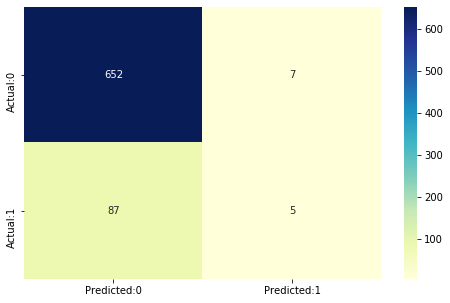

In [15]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

The confusion matrix shows 658+4 = 662 correct predictions and 88+1= 89 incorrect ones.

- True Positives:  4

- True Negatives:  658
- False Positives: 1 (*Type I error*)
- False Negatives: 88 ( *Type II error*)

In [16]:
TN=cm[0,0]
TP=cm[1,1]
FN=cm[1,0]
FP=cm[0,1]
sensitivity=TP/float(TP+FN)
specificity=TN/float(TN+FP)

### Model Evaluation - Statistics

In [18]:
print('The acuuracy of the model = TP+TN/(TP+TN+FP+FN) = ',(TP+TN)/float(TP+TN+FP+FN),'\n',

'The Missclassification = 1-Accuracy = ',1-((TP+TN)/float(TP+TN+FP+FN)),'\n',

'Sensitivity or True Positive Rate = TP/(TP+FN) = ',TP/float(TP+FN),'\n',

'Specificity or True Negative Rate = TN/(TN+FP) = ',TN/float(TN+FP),'\n',

'Positive Predictive value = TP/(TP+FP) = ',TP/float(TP+FP),'\n',

'Negative predictive Value = TN/(TN+FN) = ',TN/float(TN+FN),'\n',

'Positive Likelihood Ratio = Sensitivity/(1-Specificity) = ',sensitivity/(1-specificity),'\n',

'Negative likelihood Ratio = (1-Sensitivity)/Specificity = ',(1-sensitivity)/specificity)

The acuuracy of the model = TP+TN/(TP+TN+FP+FN) =  0.8748335552596538 
 The Missclassification = 1-Accuracy =  0.12516644474034622 
 Sensitivity or True Positive Rate = TP/(TP+FN) =  0.05434782608695652 
 Specificity or True Negative Rate = TN/(TN+FP) =  0.9893778452200304 
 Positive Predictive value = TP/(TP+FP) =  0.4166666666666667 
 Negative predictive Value = TN/(TN+FN) =  0.8822733423545331 
 Positive Likelihood Ratio = Sensitivity/(1-Specificity) =  5.116459627329198 
 Negative likelihood Ratio = (1-Sensitivity)/Specificity =  0.9558048813016804


**From the above statistics it is clear that the model is highly specific than sensitive. The negative values are predicted more accurately than the positives.**

A common way to visualize the trade-offs of different thresholds is by using an ROC curve, a plot of the true positive rate (# true positives/ total # positives) versus the false positive rate (# false positives /
total # negatives) for all possible choices of thresholds. A model with good classification accuracy should have significantly more true positives than false positives at all thresholds. 

The optimum position for roc curve is towards the top left corner where the specificity and sensitivity are at optimum levels

### Predicted probabilities of  0 (No Coronary Heart Disease) and 1 ( Coronary Heart Disease: Yes)  for the test data with a default classification threshold of 0.5

In [19]:
y_pred_prob=logreg.predict_proba(x_test)[:,:]
y_pred_prob_df=pd.DataFrame(data=y_pred_prob, columns=['Prob of no heart disease (0)','Prob of Heart Disease (1)'])
y_pred_prob_df.head()

,Prob of no heart disease (0),Prob of Heart Disease (1)
0,0.875041,0.124959
1,0.956189,0.043811
2,0.783455,0.216545
3,0.806562,0.193438
4,0.892896,0.107104


### Lower the threshold

Since the model is predicting Heart disease too many type II errors is not advisable. A False Negative ( ignoring the probability of disease when there actualy is one) is more dangerous than a False Positive in this case. Hence inorder to increase the sensitivity,  threshold can be lowered.

In [20]:
from sklearn.preprocessing import binarize
for i in range(1,5):
    cm2=0
    y_pred_prob_yes=logreg.predict_proba(x_test)
    y_pred2=binarize(y_pred_prob_yes,i/10)[:,1]
    cm2=confusion_matrix(y_test,y_pred2)
    print ('With',i/10,'threshold the Confusion Matrix is ','\n',cm2,'\n',
            'with',cm2[0,0]+cm2[1,1],'correct predictions and',cm2[1,0],'Type II errors( False Negatives)','\n\n',
          'Sensitivity: ',cm2[1,1]/(float(cm2[1,1]+cm2[1,0])),'Specificity: ',cm2[0,0]/(float(cm2[0,0]+cm2[0,1])),'\n\n\n')
    

With 0.1 threshold the Confusion Matrix is  
 [[311 348]
 [ 12  80]] 
 with 391 correct predictions and 12 Type II errors( False Negatives) 

 Sensitivity:  0.8695652173913043 Specificity:  0.47192716236722304 



With 0.2 threshold the Confusion Matrix is  
 [[518 141]
 [ 43  49]] 
 with 567 correct predictions and 43 Type II errors( False Negatives) 

 Sensitivity:  0.532608695652174 Specificity:  0.7860394537177542 



With 0.3 threshold the Confusion Matrix is  
 [[600  59]
 [ 64  28]] 
 with 628 correct predictions and 64 Type II errors( False Negatives) 

 Sensitivity:  0.30434782608695654 Specificity:  0.9104704097116844 



With 0.4 threshold the Confusion Matrix is  
 [[640  19]
 [ 80  12]] 
 with 652 correct predictions and 80 Type II errors( False Negatives) 

 Sensitivity:  0.13043478260869565 Specificity:  0.9711684370257967 





### ROC curve<font>

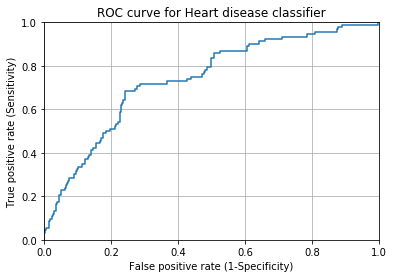

In [21]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_yes[:,1])
plt.plot(fpr,tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Heart disease classifier')
plt.xlabel('False positive rate (1-Specificity)')
plt.ylabel('True positive rate (Sensitivity)')
plt.grid(True)

A common way to visualize the trade-offs of different thresholds is by using an ROC curve, a plot of the true positive rate (# true positives/ total # positives) versus the false positive rate (# false positives /
total # negatives) for all possible choices of thresholds. A model with good classification accuracy should have significantly more true positives than false positives at all thresholds. 

The optimum position for roc curve is towards the top left corner where the specificity and sensitivity are at optimum levels

### Area Under The Curve (AUC)

The area under the ROC curve quantifies model classification accuracy; the higher the area, the greater the disparity between true and false positives, and the stronger the model in classifying members of the training dataset. An area of 0.5 corresponds to a model that performs no better than random classification and a good classifier stays as far away from that  as possible. An area of 1 is ideal. The closer the AUC to 1 the better.

In [22]:
sklearn.metrics.roc_auc_score(y_test,y_pred_prob_yes[:,1])

0.7386026258494425


## Conclusions:




 - All attributes selected after the elimination process show Pvalues lower than 5% and thereby suggesting significant role in the Heart disease prediction. 

 - Men seem to be more susceptible to heart disease than women.Increase in Age,number of cigarettes smoked per day and systolic Blood Pressure also show increasing odds of having heart disease.

 - Total cholesterol shows no significant change in the odds of CHD. This could be due to the presence of 'good cholesterol(HDL) in the total cholesterol reading.Glucose too causes a very negligible change in odds (0.2%)

 - The model predicted with 0.88 accuracy. The model is more specific than sensitive.

 - The Area under the ROC curve is 73.5 which is somewhat satisfactory.

 - Overall model could be improved with more data.

## Resource Credits

http://www.who.int/mediacentre/factsheets/fs317/en/

https://www.kaggle.com/parulpandey/deep-dive-into-logistic-regression-for-beginners


https://www.kaggle.com/amanajmera1/framingham-heart-study-dataset/data

https://www.kaggle.com/neisha/heart-disease-prediction-using-logistic-regression